In [1]:
! pip install -q accelerate peft bitsandbytes transformers trl wandb huggingface_hub ipywidgets

In [1]:
from huggingface_hub import notebook_login
import os
import wandb

wandb.login()
notebook_login()

wandb: Currently logged in as: kevinv3796. Use `wandb login --relogin` to force relogin


In [2]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [3]:
# The model that you want to train from the Hugging Face hub
model_name = "deepseek-ai/deepseek-coder-1.3b-base"

# The instruction dataset to use
dataset_name = "ArtifactAI/arxiv_python_research_code"

# Fine-tuned model name
new_model = "deepseek-coder-1.3b-python-peft"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 25

# Log every X updates steps
logging_steps = 25

#eval every X steps
eval_steps = 25

#evaluation strategy
eval_strategy = 'steps'

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

We only select a small subset of the dataset because finetuning doesn't require a huge dataset, given that our model already has a certain understanding of whatever language we're training it on.

In [4]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

#we use bitsandbytes to load the model in 4-bit. 
#This massively decreases its memory footprint and allows us to fine-train it on a free tier Colab notebook
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

Your GPU supports bfloat16: accelerate training with bf16=True


In [5]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# run down to this cell on subsequent runs if restarting the kernel and continuing runs at the end of the notebook

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Loading the base model (run upto before here to continue from runs at the bottom)

In [ ]:
from datasets import load_dataset

dataset = load_dataset(dataset_name)

# Shuffle the dataset and slice it
#trying a smaller slice for hyperparam tuning
dataset = dataset['train'].shuffle(seed=42).select(range(1000))

In [7]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Evaluation of base model

In [18]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

def generate_output(input):
    # Run text generation pipeline with our next model
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=256)
    result = pipe(input)
    print(result[0]['generated_text'])

In [20]:
prompt = """# Load a dataset using pandas
import pandas as pd
data = pd.read_csv('data.csv')

# Display the first few rows of the dataset
"""

generate_output(prompt)

# Load a dataset using pandas
import pandas as pd
data = pd.read_csv('data.csv')

# Display the first few rows of the dataset
data.head()

# Display the last few rows of the dataset
data.tail()

# Display the number of rows and columns in the dataset
data.shape

# Display the data types of each column
data.dtypes

# Display the summary statistics of the dataset
data.describe()

# Display the number of unique values in each column
data.nunique()

# Display the number of missing values in each column
data.isnull().sum()

# Display the number of unique values in each column
data.nunique()

# Display the number of missing values in each column
data.isnull().sum()

# Display the number of unique values in each column
data.nunique()

# Display the number of missing values in each column
data.isnull().sum()

# Display the number of unique values in each column
data.nunique()

# Display the number of missing values in each column
data.is


In [21]:
prompt = """# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a machine learning model (e.g., Random Forest)

"""

generate_output(prompt)

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a machine learning model (e.g., Random Forest)

# Fit the model to the training data

# Make predictions on the test data

# Evaluate the model's performance

# Use the model to make predictions on new data
<jupyter_output>
<empty_output>



In [22]:
prompt = """# Define a convolutional neural network using PyTorch
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define layers (convolutional, pooling, fully connected)
    
    def forward(self, x):
        # Define the forward pass

# Instantiate the model and show its structure
"""

generate_output(prompt)

# Define a convolutional neural network using PyTorch
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define layers (convolutional, pooling, fully connected)
    
    def forward(self, x):
        # Define the forward pass

# Instantiate the model and show its structure
model = CNN()
print(model)
<jupyter_output>
<empty_output>



In [23]:
prompt = """# Preprocess text data for sentiment analysis
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

text = "This is a sample sentence for tokenization."
tokens = word_tokenize(text)

# Display the tokens

"""

generate_output(prompt)

# Preprocess text data for sentiment analysis
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

text = "This is a sample sentence for tokenization."
tokens = word_tokenize(text)

# Display the tokens

print(tokens)
<jupyter_output>
['This', 'is', 'a','sample','sentence', 'for', 'tokenization', '.']
<jupyter_text>
Stemming and Lemmatization
<jupyter_code>
# Import the necessary libraries
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Define the text
text = "This is a sample sentence for tokenization."

# Create a PorterStemmer object
stemmer = PorterStemmer()

# Stem the text
stemmed_text = stemmer.stem(text)

# Display the stemmed text
print(stemmed_text)

# Create a Word


In [24]:
prompt = """# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
"""

generate_output(prompt)

# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
title = soup.find('title').text
links = [link.get('href') for link in soup.find_all('a')]

# Print the extracted information
print(f'Title: {title}')
print(f'Links: {links}')

# Use Selenium to scrape a webpage
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = webdriver.Firefox()
driver.get('https://example.com')

# Wait for the page to load
wait = WebDriverWait(driver, 10)
wait.until(EC.presence


In [25]:
prompt = """# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
"""

generate_output(prompt)

# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
title = soup.find('title').text
links = [link.get('href') for link in soup.find_all('a')]

# Print the extracted information
print(f'Title: {title}')
print(f'Links: {links}')

# Use Selenium to scrape a webpage
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = webdriver.Firefox()
driver.get('https://example.com')

# Wait for the page to load
wait = WebDriverWait(driver, 10)
wait.until(EC.presence


In [26]:
prompt = """# Perform matrix operations with NumPy
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Compute the dot product of A and B
"""

generate_output(prompt)

# Perform matrix operations with NumPy
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Compute the dot product of A and B
dot_product = np.dot(A, B)

# Print the dot product
print(dot_product)

# Perform matrix operations with NumPy
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Compute the dot product of A and B
dot_product = np.dot(A, B)

# Print the dot product
print(dot_product)

# Perform matrix operations with NumPy
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Compute the dot product of


In [27]:
prompt = """# Create a 3D plot using matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Display the 3D surface plot
"""

generate_output(prompt)

# Create a 3D plot using matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Display the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='rainbow')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
<jupyter_output>
<empty_output>
<jupyter_text>
3.3.2.3.3.4.5.6.7.8.9.10.1


## Fine-tune model

In [28]:
os.environ["WANDB_PROJECT"] = "python-autocomplete-deepseek"

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    eval_strategy = eval_strategy,
    eval_steps = eval_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="wandb"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="code",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [29]:
# Train model
trainer.train()

{'loss': 0.7796, 'grad_norm': 0.030525265261530876, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.9035, 'grad_norm': 0.0, 'learning_rate': 0.0002, 'epoch': 0.04}
{'loss': 0.8093, 'grad_norm': 0.036525554955005646, 'learning_rate': 0.0002, 'epoch': 0.06}
{'loss': 0.9395, 'grad_norm': 0.0, 'learning_rate': 0.0002, 'epoch': 0.08}
{'loss': 0.8034, 'grad_norm': 0.04083041846752167, 'learning_rate': 0.0002, 'epoch': 0.1}
{'loss': 0.8616, 'grad_norm': 0.0, 'learning_rate': 0.0002, 'epoch': 0.12}
{'loss': 0.7796, 'grad_norm': 0.04836655780673027, 'learning_rate': 0.0002, 'epoch': 0.14}
{'loss': 0.9909, 'grad_norm': 0.0, 'learning_rate': 0.0002, 'epoch': 0.16}
{'loss': 0.8906, 'grad_norm': 0.039162393659353256, 'learning_rate': 0.0002, 'epoch': 0.18}
{'loss': 0.8593, 'grad_norm': 1.3608026504516602, 'learning_rate': 0.0002, 'epoch': 0.2}
{'loss': 0.8359, 'grad_norm': 0.03401603922247887, 'learning_rate': 0.0002, 'epoch': 0.22}
{'loss': 0.9379, 'grad_norm': 0.0, 'learning_rate': 0.0002, 'ep

In [30]:
wandb.run.finish()

train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▁▅▂▆▃▁▇▄▃▅▄▂▄▃▄▃▁▂▁▇▄▂▄▁▃▃▃▇█▄▄▃▂▃▂▆▂▃▄▃
total_flos,2.874581368209408e+16
train/epoch,1.0
train/global_step,1250
train/grad_norm,0.0
train/learning_rate,0.0002
train/loss,0.8478


### Hyperparam Tuning
The training above was quite unstable, since we saw exploding and vanishing gradients. We might need to train with different hyperparams.

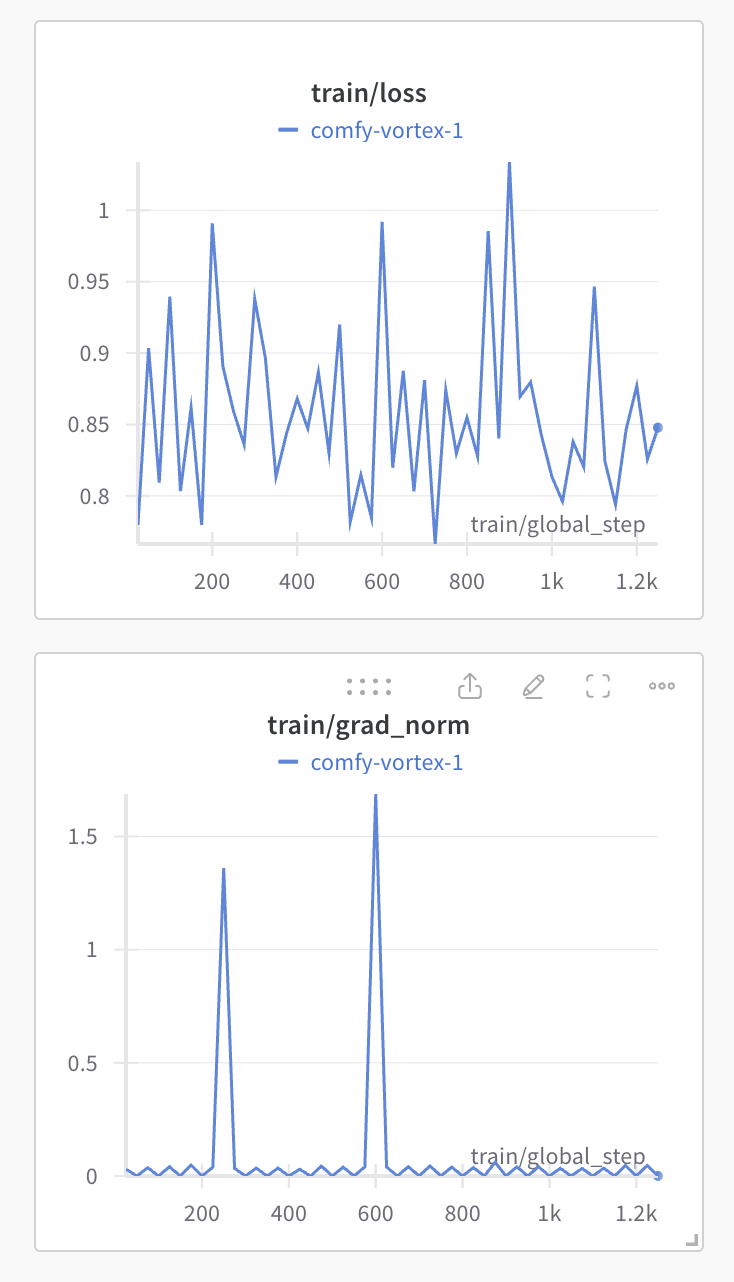

### Run 1: Learning Rate

In [31]:
# Initial learning rate (AdamW optimizer)
learning_rate = 5e-5

In [32]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    eval_strategy = eval_strategy,
    eval_steps = eval_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="wandb"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="code",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [33]:
trainer.train()

{'loss': 0.7813, 'grad_norm': 0.022311056032776833, 'learning_rate': 5e-05, 'epoch': 0.02}
{'loss': 0.9155, 'grad_norm': 0.0, 'learning_rate': 5e-05, 'epoch': 0.04}
{'loss': 0.8129, 'grad_norm': 0.03203234449028969, 'learning_rate': 5e-05, 'epoch': 0.06}
{'loss': 0.9599, 'grad_norm': 0.0, 'learning_rate': 5e-05, 'epoch': 0.08}
{'loss': 0.8052, 'grad_norm': 0.04477047547698021, 'learning_rate': 5e-05, 'epoch': 0.1}
{'loss': 0.8883, 'grad_norm': 0.0, 'learning_rate': 5e-05, 'epoch': 0.12}
{'loss': 0.7807, 'grad_norm': 0.05843821540474892, 'learning_rate': 5e-05, 'epoch': 0.14}
{'loss': 1.0097, 'grad_norm': 0.0, 'learning_rate': 5e-05, 'epoch': 0.16}
{'loss': 0.8907, 'grad_norm': 0.04959563538432121, 'learning_rate': 5e-05, 'epoch': 0.18}
{'loss': 0.878, 'grad_norm': 1.9280540943145752, 'learning_rate': 5e-05, 'epoch': 0.2}
{'loss': 0.8375, 'grad_norm': 0.04590395465493202, 'learning_rate': 5e-05, 'epoch': 0.22}


KeyboardInterrupt: 

In [34]:
wandb.run.finish() #finish previous run

train/epoch,▁▂▂▃▄▄▅▆▇▇█
train/global_step,▁▂▂▃▄▅▅▆▇▇█
train/grad_norm,▁▁▁▁▁▁▁▁▁█▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁
train/loss,▁▅▂▆▂▄▁█▄▄▃
train/epoch,0.22
train/global_step,275
train/grad_norm,0.0459
train/learning_rate,5e-05
train/loss,0.8375


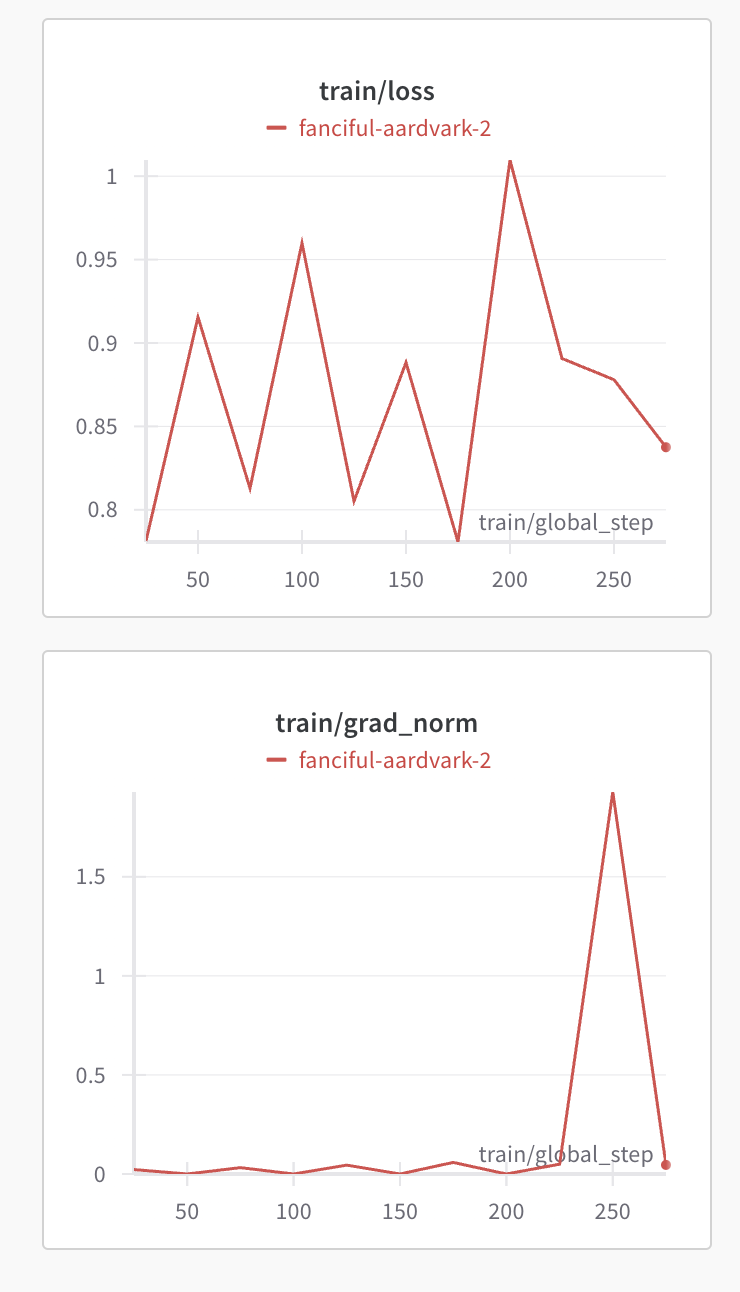

I interrupted the training since we were again seeing exploding and vanishing gradients. Let's try gradient clipping and accumulation.

### Run 2: Gradient clipping and accumulation
Let's try different values of gradient clipping

In [7]:
# Initial learning rate (AdamW optimizer)
learning_rate = 5e-4 #initial learning rate

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.1

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    eval_strategy = eval_strategy,
    eval_steps = eval_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="wandb"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="code",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


KeyboardInterrupt: 

This way of carrying out sweeps is quite slow and cumbersome, let's try out a better way like Weights and Biases Sweeps

## Sweeping with Wandb

In [8]:
from datasets import load_dataset

os.environ["WANDB_PROJECT"] = "python-autocomplete-deepseek"

dataset = load_dataset(dataset_name)

#trying a smaller slice for hyperparam tuning
dataset = dataset['train'].shuffle(seed=42).select(range(500))

def model_init():
    model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
    model.config.use_cache = False
    model.config.pretraining_tp = 1
    return model

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/26 [00:00<?, ?it/s]

In [9]:
# method
sweep_config = {
    'method': 'random'
}


# hyperparameters
parameters_dict = {
    'max_grad_norm': {
        'values': [0.001, 0.01, 0.1]
    },
    'learning_rate': {
        'distribution': 'log_uniform_values',
        'min': 1e-5,
        'max': 2e-4
    },
    'weight_decay': {
        'values': [0.001, 0.01, 0.1]
    },
    'lr_scheduler_type':{
        'values': ['cosine', 'linear', 'constant']
    },
    'optim': {
        'values': ['paged_adamw_32bit', 'paged_lion_32bit', 'rmsprop_bnb_32bit']
    }
}


sweep_config['parameters'] = parameters_dict


In [10]:
model = model_init()

In [11]:
def train(config = None):
  with wandb.init(config=config):
      config = wandb.config
      
      peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        r=lora_r,
        bias="none",
        task_type="CAUSAL_LM",
    )
      training_arguments = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        optim=config.optim,
        save_steps=save_steps,
        eval_strategy = eval_strategy,
        eval_steps = eval_steps,
        logging_steps=logging_steps,
        learning_rate=config.learning_rate,
        weight_decay=config.weight_decay,
        fp16=fp16,
        bf16=bf16,
        max_grad_norm=config.max_grad_norm,
        max_steps=max_steps,
        warmup_ratio=warmup_ratio,
        group_by_length=group_by_length,
        lr_scheduler_type=config.lr_scheduler_type,
        report_to="wandb"
    )
      # Set supervised fine-tuning parameters
      trainer = SFTTrainer(
        model=model,
        train_dataset=dataset,
        peft_config=peft_config,
        dataset_text_field="code",
        max_seq_length=max_seq_length,
        tokenizer=tokenizer,
        args=training_arguments,
        packing=packing,
    )
      trainer.train()

In [12]:
sweep_id = wandb.sweep(sweep_config, project=os.environ.get('WANDB_PROJECT'))

Create sweep with ID: 0g14eyg1
Sweep URL: https://wandb.ai/kevinv3796/python-autocomplete-deepseek/sweeps/0g14eyg1


In [13]:
wandb.agent(sweep_id, train, count=20)

wandb: Agent Starting Run: pw6arn36 with config:
wandb: 	learning_rate: 3.500790069713788e-05
wandb: 	lr_scheduler_type: cosine
wandb: 	max_grad_norm: 0.01
wandb: 	optim: paged_adamw_32bit
wandb: 	weight_decay: 0.001


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866700
50,0.921900
75,0.932000
100,0.882200
125,0.893900


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▆▁▂▂
train/learning_rate,█▆▄▂▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.03198
train/learning_rate,0.0
train/loss,0.8939


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l2vzsvuz with config:
wandb: 	learning_rate: 1.2264940320639783e-05
wandb: 	lr_scheduler_type: constant
wandb: 	max_grad_norm: 0.01
wandb: 	optim: rmsprop_bnb_32bit
wandb: 	weight_decay: 0.001


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866500
50,0.922200
75,0.933700
100,0.885800
125,0.896100


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▅▁▁▂
train/learning_rate,▁▁▁▁▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.0222
train/learning_rate,1e-05
train/loss,0.8961


wandb: Agent Starting Run: g38kk3fm with config:
wandb: 	learning_rate: 3.206334564524053e-05
wandb: 	lr_scheduler_type: linear
wandb: 	max_grad_norm: 0.1
wandb: 	optim: paged_adamw_32bit
wandb: 	weight_decay: 0.1


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866700
50,0.922200
75,0.932700
100,0.883300
125,0.894300


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▅▁▂▂
train/learning_rate,█▆▄▃▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.03022
train/learning_rate,0.0
train/loss,0.8943


wandb: Agent Starting Run: ykiu8dhu with config:
wandb: 	learning_rate: 1.7996546838951693e-05
wandb: 	lr_scheduler_type: cosine
wandb: 	max_grad_norm: 0.001
wandb: 	optim: paged_lion_32bit
wandb: 	weight_decay: 0.01


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866900
50,0.923400
75,0.935400
100,0.888700
125,0.898400


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▅▂▁▁
train/learning_rate,█▆▄▂▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.02098
train/learning_rate,0.0
train/loss,0.8984


wandb: Agent Starting Run: uflf7yvx with config:
wandb: 	learning_rate: 2.6651998012051903e-05
wandb: 	lr_scheduler_type: cosine
wandb: 	max_grad_norm: 0.001
wandb: 	optim: rmsprop_bnb_32bit
wandb: 	weight_decay: 0.001


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866700
50,0.922700
75,0.934800
100,0.887900
125,0.897800


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▅▁▁▂
train/learning_rate,█▆▄▂▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.01793
train/learning_rate,0.0
train/loss,0.8978


wandb: Agent Starting Run: xl6cdzf5 with config:
wandb: 	learning_rate: 1.4718531601932032e-05
wandb: 	lr_scheduler_type: linear
wandb: 	max_grad_norm: 0.01
wandb: 	optim: paged_lion_32bit
wandb: 	weight_decay: 0.001


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866800
50,0.923100
75,0.934700
100,0.887500
125,0.897400


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▅▂▁▂
train/learning_rate,█▆▅▃▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.02168
train/learning_rate,0.0
train/loss,0.8974


wandb: Agent Starting Run: l0txnr88 with config:
wandb: 	learning_rate: 0.00018491345903756033
wandb: 	lr_scheduler_type: constant
wandb: 	max_grad_norm: 0.001
wandb: 	optim: paged_adamw_32bit
wandb: 	weight_decay: 0.001


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.865300
50,0.912900
75,0.917900
100,0.851600
125,0.878700


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▆▁▁▂
train/learning_rate,▁▁▁▁▁
train/loss,▂▇█▁▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.0428
train/learning_rate,0.00018
train/loss,0.8787


wandb: Agent Starting Run: 7mv99gz7 with config:
wandb: 	learning_rate: 1.0391714151607868e-05
wandb: 	lr_scheduler_type: linear
wandb: 	max_grad_norm: 0.01
wandb: 	optim: paged_adamw_32bit
wandb: 	weight_decay: 0.1


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866800
50,0.923200
75,0.934800
100,0.887600
125,0.897600


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▅▂▁▂
train/learning_rate,█▆▅▃▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.0254
train/learning_rate,0.0
train/loss,0.8976


wandb: Agent Starting Run: uvhclaon with config:
wandb: 	learning_rate: 1.2494221091361708e-05
wandb: 	lr_scheduler_type: constant
wandb: 	max_grad_norm: 0.1
wandb: 	optim: rmsprop_bnb_32bit
wandb: 	weight_decay: 0.01


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866600
50,0.922400
75,0.934100
100,0.886700
125,0.897000


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▅▁▁▂
train/learning_rate,▁▁▁▁▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.01966
train/learning_rate,1e-05
train/loss,0.897


wandb: Agent Starting Run: a4er3flz with config:
wandb: 	learning_rate: 1.5547540087631355e-05
wandb: 	lr_scheduler_type: constant
wandb: 	max_grad_norm: 0.1
wandb: 	optim: rmsprop_bnb_32bit
wandb: 	weight_decay: 0.1


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866800
50,0.923100
75,0.935200
100,0.888400
125,0.898300


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▅▁▁▁
train/learning_rate,▁▁▁▁▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.0177
train/learning_rate,2e-05
train/loss,0.8983


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bw7qevaa with config:
wandb: 	learning_rate: 5.0321442113316194e-05
wandb: 	lr_scheduler_type: constant
wandb: 	max_grad_norm: 0.01
wandb: 	optim: paged_adamw_32bit
wandb: 	weight_decay: 0.1


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866400
50,0.920700
75,0.928500
100,0.870900
125,0.884700


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▆▁▃▆
train/learning_rate,▁▁▁▁▁
train/loss,▁▇█▂▃
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.04523
train/learning_rate,5e-05
train/loss,0.8847


wandb: Agent Starting Run: u81h6oe0 with config:
wandb: 	learning_rate: 0.0001544229966088366
wandb: 	lr_scheduler_type: cosine
wandb: 	max_grad_norm: 0.01
wandb: 	optim: paged_adamw_32bit
wandb: 	weight_decay: 0.001


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.865700
50,0.914300
75,0.920100
100,0.860000
125,0.882700


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▆▁▁▂
train/learning_rate,█▆▄▂▁
train/loss,▂▇█▁▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.04384
train/learning_rate,0.0
train/loss,0.8827


wandb: Agent Starting Run: xwrsm9zz with config:
wandb: 	learning_rate: 0.00015180972066017458
wandb: 	lr_scheduler_type: linear
wandb: 	max_grad_norm: 0.1
wandb: 	optim: rmsprop_bnb_32bit
wandb: 	weight_decay: 0.001


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.864900
50,0.906200
75,0.919900
100,0.860500
125,0.884200


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▆▁▂▃
train/learning_rate,█▆▅▃▁
train/loss,▂▆█▁▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.03082
train/learning_rate,0.0
train/loss,0.8842


wandb: Agent Starting Run: ao6kjnsl with config:
wandb: 	learning_rate: 6.821981023710127e-05
wandb: 	lr_scheduler_type: cosine
wandb: 	max_grad_norm: 0.001
wandb: 	optim: rmsprop_bnb_32bit
wandb: 	weight_decay: 0.001


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866600
50,0.922600
75,0.934900
100,0.888000
125,0.897900


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▄▁▁▁
train/learning_rate,█▆▄▂▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.01281
train/learning_rate,0.0
train/loss,0.8979


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lsjztnoe with config:
wandb: 	learning_rate: 6.64660261675825e-05
wandb: 	lr_scheduler_type: cosine
wandb: 	max_grad_norm: 0.1
wandb: 	optim: rmsprop_bnb_32bit
wandb: 	weight_decay: 0.1


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866900
50,0.923000
75,0.935300
100,0.888600
125,0.898300


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▄▁▁▁
train/learning_rate,█▆▄▂▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.01193
train/learning_rate,0.0
train/loss,0.8983


wandb: Agent Starting Run: hchd5o6c with config:
wandb: 	learning_rate: 1.69329571328349e-05
wandb: 	lr_scheduler_type: constant
wandb: 	max_grad_norm: 0.01
wandb: 	optim: rmsprop_bnb_32bit
wandb: 	weight_decay: 0.01


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866600
50,0.922800
75,0.934800
100,0.887800
125,0.897800


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▅▁▁▁
train/learning_rate,▁▁▁▁▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.01762
train/learning_rate,2e-05
train/loss,0.8978


wandb: Agent Starting Run: le5f60f3 with config:
wandb: 	learning_rate: 1.055504853440168e-05
wandb: 	lr_scheduler_type: cosine
wandb: 	max_grad_norm: 0.001
wandb: 	optim: rmsprop_bnb_32bit
wandb: 	weight_decay: 0.1


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866900
50,0.923500
75,0.935500
100,0.888800
125,0.898500


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▅▂▁▁
train/learning_rate,█▆▄▂▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.02059
train/learning_rate,0.0
train/loss,0.8985


wandb: Agent Starting Run: z8djth3t with config:
wandb: 	learning_rate: 0.00010510591718098867
wandb: 	lr_scheduler_type: constant
wandb: 	max_grad_norm: 0.01
wandb: 	optim: paged_lion_32bit
wandb: 	weight_decay: 0.001


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866300
50,0.920500
75,0.930600
100,0.878200
125,0.890100


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▅▁▂▃
train/learning_rate,▁▁▁▁▁
train/loss,▁▇█▂▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.02482
train/learning_rate,0.00011
train/loss,0.8901


wandb: Agent Starting Run: rqy9s3ou with config:
wandb: 	learning_rate: 5.319132290727162e-05
wandb: 	lr_scheduler_type: cosine
wandb: 	max_grad_norm: 0.01
wandb: 	optim: rmsprop_bnb_32bit
wandb: 	weight_decay: 0.01


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866600
50,0.922600
75,0.934800
100,0.887900
125,0.897900


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▄▁▁▁
train/learning_rate,█▆▄▂▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.01434
train/learning_rate,0.0
train/loss,0.8979


wandb: Agent Starting Run: 86ex87kw with config:
wandb: 	learning_rate: 0.00016502836302896635
wandb: 	lr_scheduler_type: constant
wandb: 	max_grad_norm: 0.001
wandb: 	optim: paged_lion_32bit
wandb: 	weight_decay: 0.001


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_grad_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optim' was locked by 'sweep' (ignored update).


Step,Training Loss
25,0.866600
50,0.922600
75,0.935000
100,0.887700
125,0.897800


train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,█▄▁▁▁
train/learning_rate,▁▁▁▁▁
train/loss,▁▇█▃▄
total_flos,2854807861002240.0
train/epoch,1.0
train/global_step,125
train/grad_norm,0.00873
train/learning_rate,0.00017
train/loss,0.8978


From the parameter sweep above (details of which you can see at https://api.wandb.ai/links/kevinv3796/edmcmz77), we can see that a good set of parameters is:
- Learning rate = 2e-3 (learning rate was the most correlated with the avg loss)
- lr_scheduler_type = constant (I changed this later with more experiments for better training)
- max_grad_norm = 0.001
- optim = paged_adamw_32bit
- weight_decay = 0.001

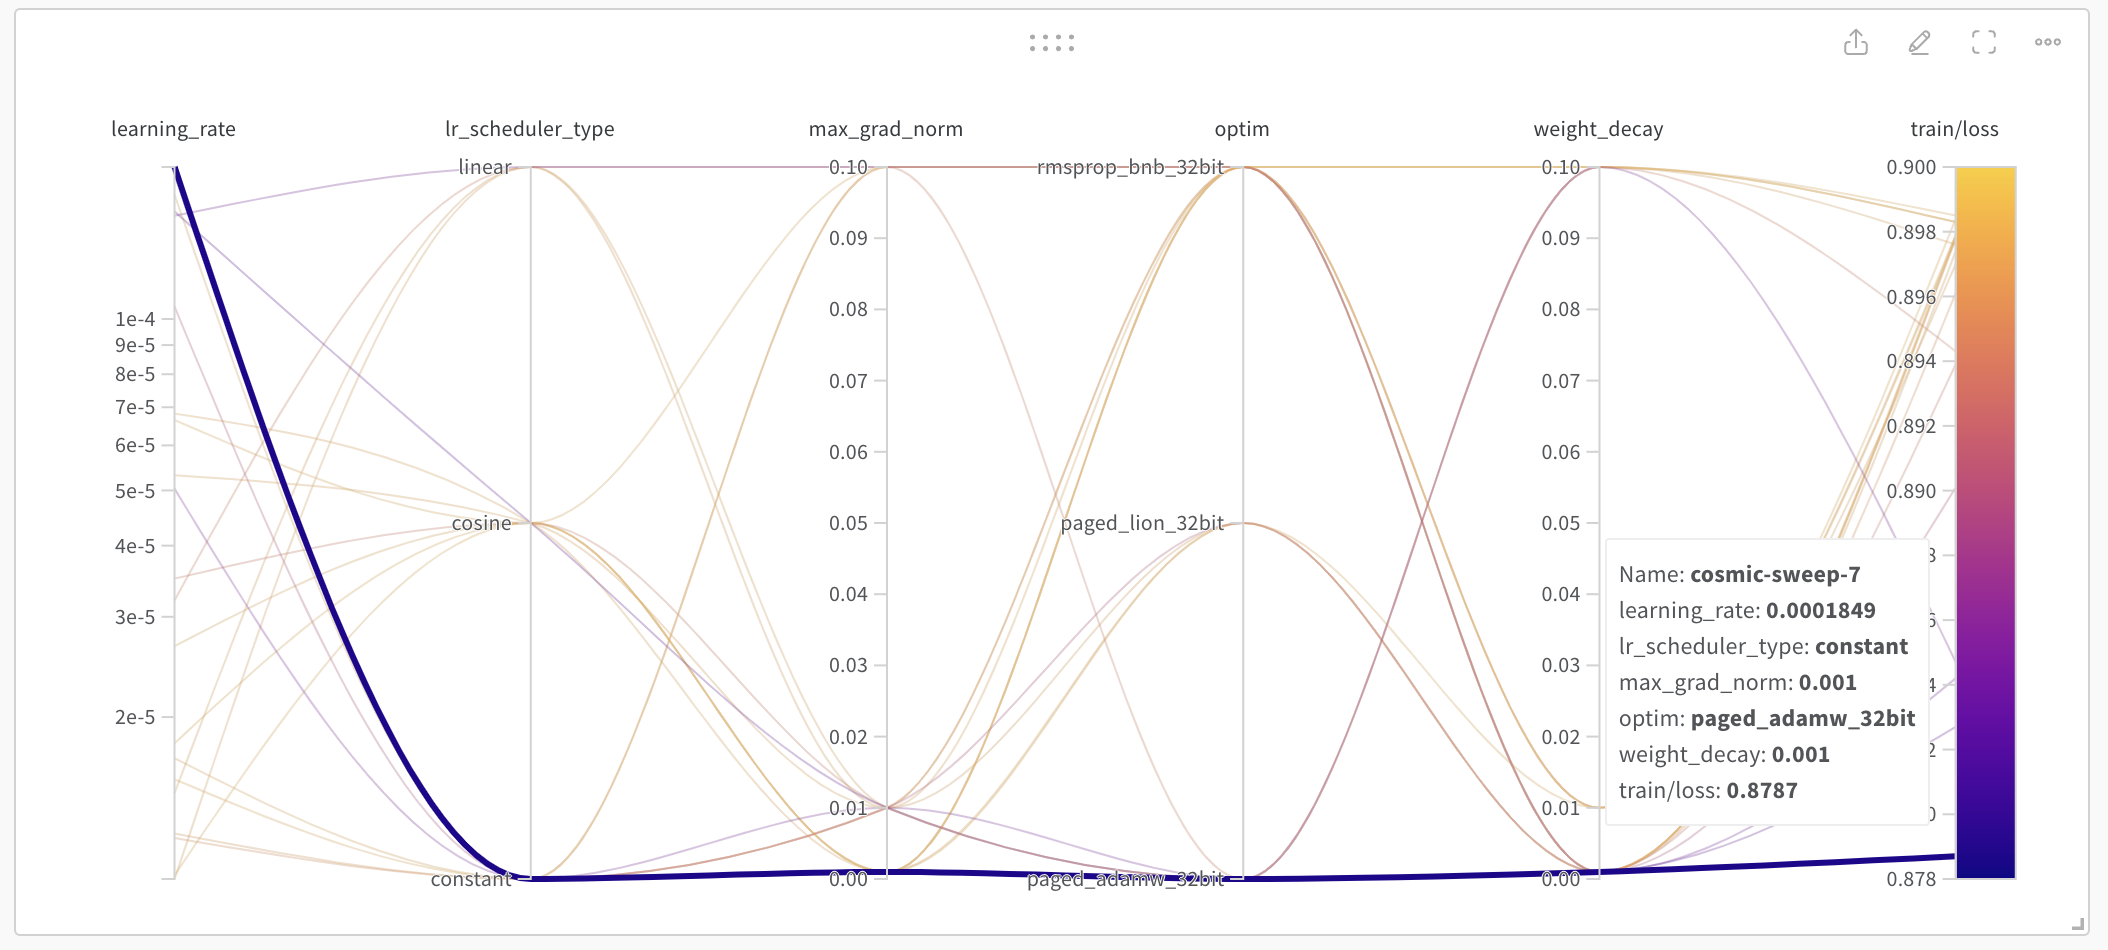

# Final Training
Now that we know a good set of hyperparams, let's finetune the model on them on a bigger subset of the dataset, for a longer time and then see how our finetuned model compares to our initial evaluation of the base model.

In [6]:
from datasets import load_dataset

os.environ["WANDB_PROJECT"] = "python-autocomplete-deepseek"

learning_rate = 2e-3 
lr_scheduler_type = 'cosine_with_restarts'
max_grad_norm = 0.001
weight_decay = 0.001
num_train_epochs = 15
eval_strategy = "steps"
eval_steps = 25

dataset = load_dataset(dataset_name)

#Shuffle the dataset and slice it
#Bigger slice for training
train_dataset = dataset['train'].shuffle(seed=42).select(range(1000))
eval_dataset = dataset['train'].shuffle(seed=42).select(range(25))

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    evaluation_strategy = eval_strategy,
    eval_steps = eval_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="wandb"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset = eval_dataset,
    peft_config=peft_config,
    dataset_text_field="code",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [7]:
trainer.train()

Step,Training Loss,Validation Loss
25,0.789200,0.825764
50,0.995600,0.817905
75,0.847100,0.813906
100,0.879300,0.826335
125,0.878100,0.817937
150,0.844600,0.844661
175,0.863200,0.807063
200,0.895700,0.823050
225,0.850700,0.799115
250,0.944000,0.799816


TrainOutput(global_step=3750, training_loss=0.3423475600242615, metrics={'train_runtime': 6193.5414, 'train_samples_per_second': 2.422, 'train_steps_per_second': 0.605, 'total_flos': 8.568287050752e+16, 'train_loss': 0.3423475600242615, 'epoch': 15.0})

These were the metrics in the final run:

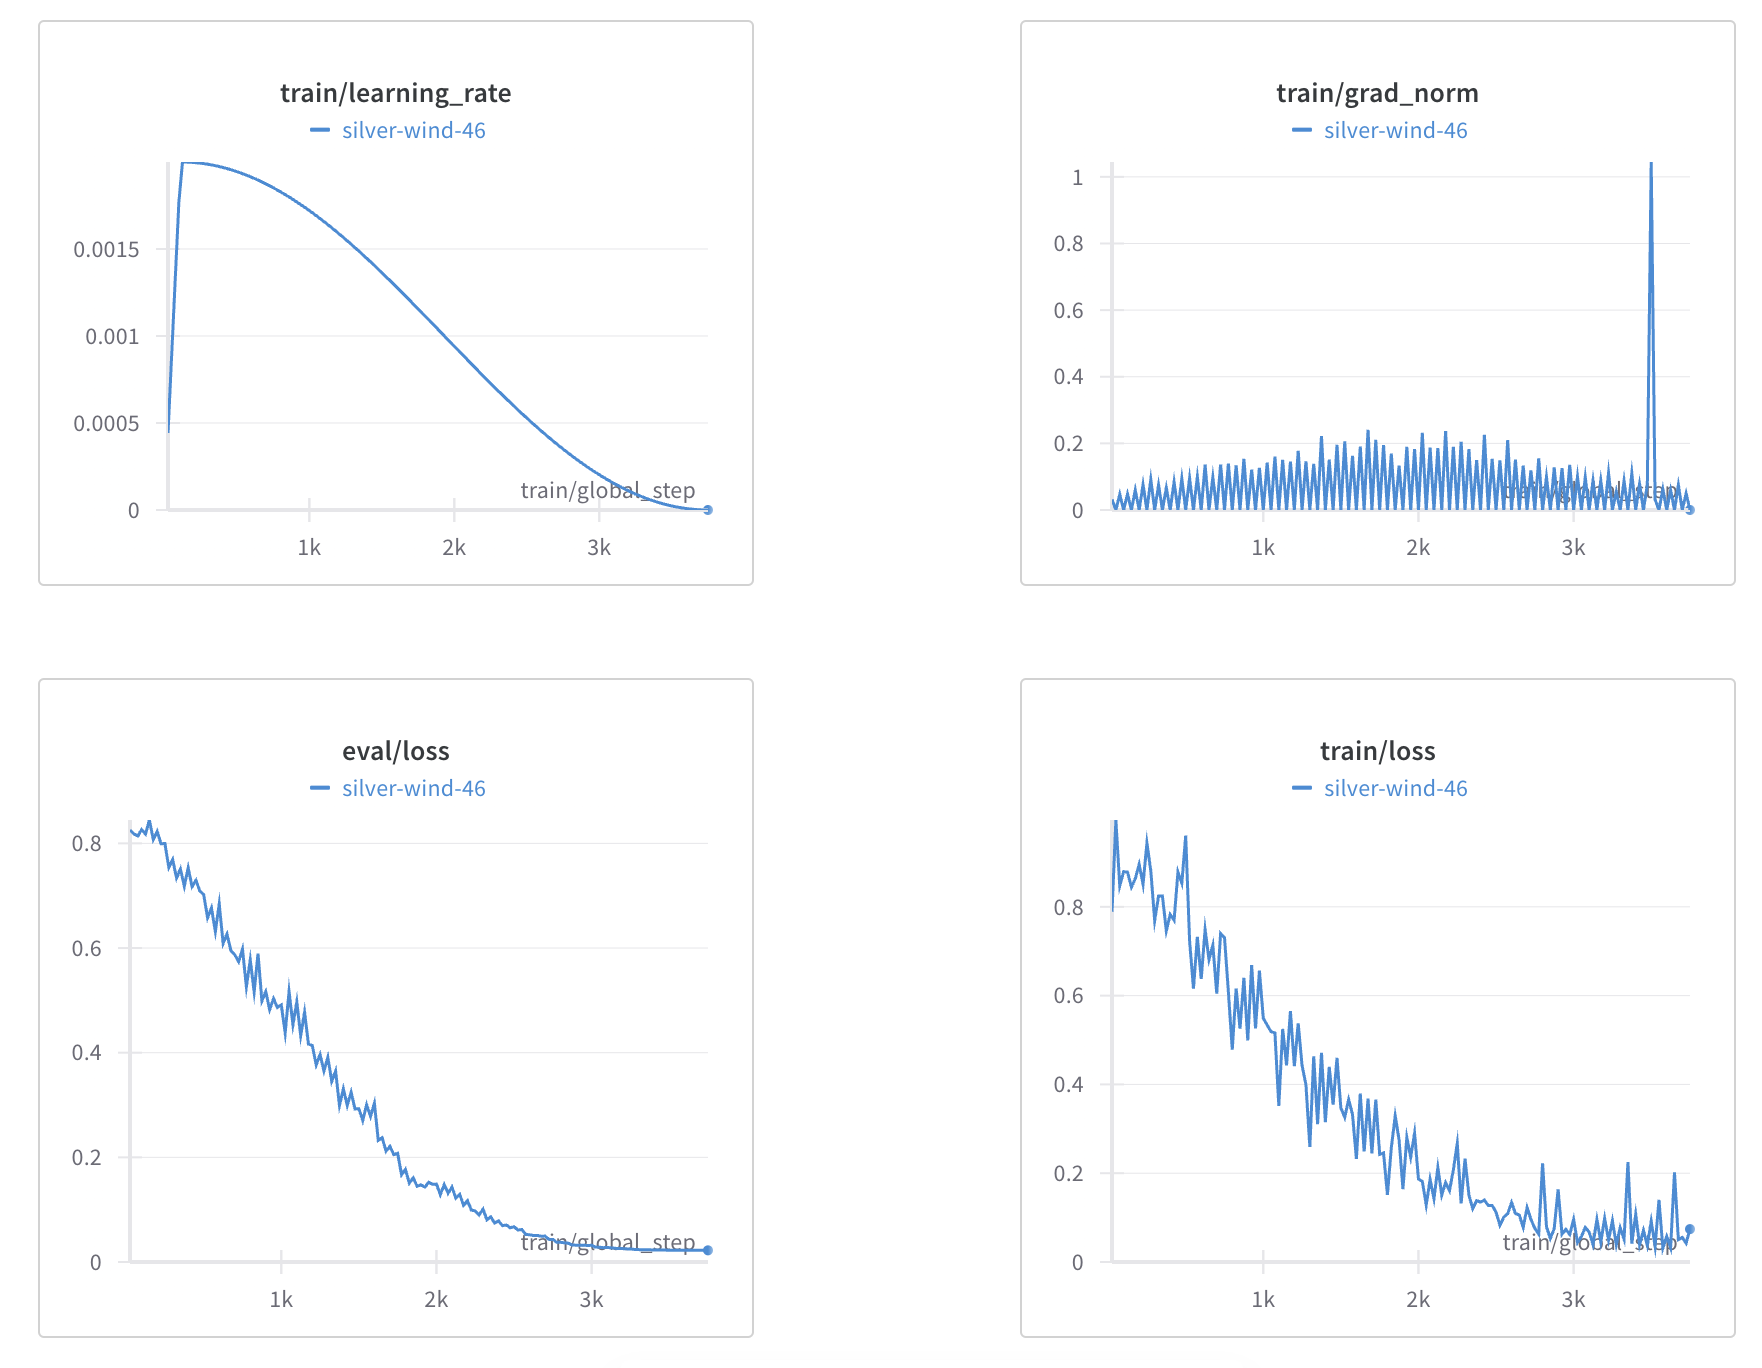

We saw some instability in gradient norms, but the overall trend in loss was downwards and the validation loss almost plateaud.

In [8]:
wandb.run.finish()

eval/loss,████▇▇▇▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇▇██▇▇▇█▇▇▇▇▇▇▇▇▇▆▇
eval/samples_per_second,█▂▂▂▁▂▂▂▃▂▂▂▂▁▂▂▂▂▁▂▂▂▂▁▁▁▂▂▁▂▂▂▂▂▁▂▂▂▃▂
eval/steps_per_second,█▂▁▂▁▂▁▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▂▁▁▁▂▂▁▂▂▂▂▁▁▂▂▂▂▂
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/grad_norm,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▄▇██████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train/loss,█▇▇▆▆█▅▅▄▄▅▄▄▄▃▃▃▂▂▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▂▂▁
eval/loss,0.02227
eval/runtime,5.7584


For the above training I forgot to pass a few params that run evaluation, so I ran the training for a few more epochs to get a sense for eval performance and whether there was any overfitting before doing vibes-based eval on the model and saving it.

# Final Model Eval

In [9]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

def generate_output(input):
    # Run text generation pipeline with our next model
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=256)
    result = pipe(input)
    print(result[0]['generated_text'])

In [10]:
prompt = """# Load a dataset using pandas
import pandas as pd
data = pd.read_csv('data.csv')

# Display the first few rows of the dataset
"""

generate_output(prompt)

# Load a dataset using pandas
import pandas as pd
data = pd.read_csv('data.csv')

# Display the first few rows of the dataset
data.head(10)

# Get information about the dataset
data.info()

# Get the index
for i in data.index:
    print(i)

# Get the number of observations
n_obs = data.shape[0]
print(n_obs)

# Get the number of columns
n_cols = data.shape[1]
print(n_cols)

# Get the list of columns
cols = data.columns
print(cols)

# Select a single column
sel_col = data['Country']
print(sel_col)

# Select multiple columns
sel_cols = data[['Country','Age']]
print(sel_cols)

# Select rows
# You can select by index, or by passing a list of indices
# By index, you can select by country using the following example
country_df = data.loc[data['Country']=='


In [11]:
prompt = """# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a machine learning model (e.g., Random Forest)

"""

generate_output(prompt)

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a machine learning model (e.g., Random Forest)

# Split data into features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an empty list to store accuracy scores
accuracies = []

# Iterate over different values of the regularization parameter for penalization
for alpha in [0.01, 0.1, 1, 10, 100, 1000]:
    # Instantiate a logistic regression model
    logreg = LogisticRegression(C=alpha, random_state=42)
    
    # Fit logistic regression to the training data
    logreg.fit(X


In [12]:
prompt = """# Define a convolutional neural network using PyTorch
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define layers (convolutional, pooling, fully connected)
    
    def forward(self, x):
        # Define the forward pass

# Instantiate the model and show its structure
"""

generate_output(prompt)

# Define a convolutional neural network using PyTorch
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define layers (convolutional, pooling, fully connected)
    
    def forward(self, x):
        # Define the forward pass

# Instantiate the model and show its structure
model = CNN()
print(model)

# Get information about the model's architecture
print(model.named_parameters())

# Import image classes
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# Load the image class dataset
dataset = ImageFolder('../data/image_classes', transform=transforms.ToTensor())
train_dataset, test_dataset = dataset[:5000], dataset[5000:]
train_dataloader = DataLoader(


In [13]:
prompt = """# Preprocess text data for sentiment analysis
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

text = "This is a sample sentence for tokenization."
tokens = word_tokenize(text)

# Display the tokens

"""

generate_output(prompt)

# Preprocess text data for sentiment analysis
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

text = "This is a sample sentence for tokenization."
tokens = word_tokenize(text)

# Display the tokens

print(tokens)

# Preprocess text data for word frequency analysis

import re
from collections import Counter

data = ["This is the first sentence.", "This is the second sentence.", "This is the third sentence.", "This is the fourth sentence.", "This is the fifth sentence"]

word_freq = Counter([word for sentence in data for word in re.findall(r'\w+', sentence)])

print(word_freq)

# Compute sentiment analysis
import numpy as np
import spacy

nlp = spacy.load('en_core_web_sm')

def sentiment(text):
    doc = nlp(text)
    return np.around(doc[0].vector.dot(doc[1].vector), 2)

sentiment("I


In [14]:
prompt = """# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
"""

generate_output(prompt)

# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
title = soup.find('title').text
print('Title:', title)

h1s = soup.find_all('h1')
print('Number of h1 tags:', len(h1s))

for h1 in h1s:
    print(h1.text)

# Example of using CSS selectors
# More info: https://www.w3schools.com/css/css_syntax.asp

import cssselect
title = soup.cssselect('title')[0].text
print('Title:', title)

h1s = soup.cssselect('h1')
print('Number of h1 tags:', len(h1s))

for h1 in h1s:
    print(h1.text)

# Save


In [16]:
prompt = """# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
"""

generate_output(prompt)

# Scrape a webpage using BeautifulSoup
from bs4 import BeautifulSoup
import requests

url = 'https://example.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract specific information from the webpage
title = soup.find('title').text
print('Title:', title)

h1s = soup.find_all('h1')
print('Number of h1 tags:', len(h1s))

for h1 in h1s:
    print(h1.text)

# Example of using CSS selectors
# More info: https://www.w3schools.com/css/css_syntax.asp

import cssselect
title = soup.cssselect('title')[0].text
print('Title:', title)

h1s = soup.cssselect('h1')
print('Number of h1 tags:', len(h1s))

for h1 in h1s:
    print(h1.text)

# Save


In [17]:
prompt = """# Perform matrix operations with NumPy
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Compute the dot product of A and B
"""

generate_output(prompt)

# Perform matrix operations with NumPy
import numpy as np

A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Compute the dot product of A and B
print(np.dot(A, B))

# Compute the element-wise sum of A and B
print(np.sum(A + B))

# Compute the sum of each column of A
print(np.sum(A, axis=0))

# Compute the sum of each row of A
print(np.sum(A, axis=1))

# Multiply matrix A with matrix B
print(np.dot(A, B))

# Transpose matrix A
print(np.transpose(A))

# Get the determinant of matrix A
print(np.linalg.det(A))

# Get the inverse of matrix A
print(np.linalg.inv(A))

# Get the eigenvalue and eigenvector of matrix A
eigenvalues, eigen


In [18]:
prompt = """# Create a 3D plot using matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Display the 3D surface plot
"""

generate_output(prompt)

# Create a 3D plot using matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Display the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

plt.show()

# Create a 2D plot using matplotlib
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z


As we can see, depending on how many tokens we generate, our model does seem to predict better code.

In [19]:
# we'll have to save our model, restart the notebook (for vram purposes), then merge our low rank adapters with the base model.
# see: https://mlabonne.github.io/blog/posts/Fine_Tune_Your_Own_Llama_2_Model_in_a_Colab_Notebook.html
trainer.model.save_pretrained(new_model)

# Save Model

In [4]:
# Reload model in FP16 and merge it with LoRA weights - this needs to be done after restarting the kernel and loading the model again
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)

model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/MadMarx37/deepseek-coder-1.3b-python-peft/commit/9d7d0bd86adfe139d5e459bc6fd43f6d5371d187', commit_message='Upload tokenizer', commit_description='', oid='9d7d0bd86adfe139d5e459bc6fd43f6d5371d187', pr_url=None, pr_revision=None, pr_num=None)